# 注意力汇聚
查询（⾃主提⽰）和键（⾮⾃主提⽰）之间的交互形成了注意⼒汇聚；注意⼒汇聚有选择地聚合了值（感官输⼊）以⽣成最终的输出。本节将介绍注意⼒汇聚的更多细节，以便从宏观上了解注意⼒机制在实践中的运作⽅式。具体来说，1964年提出的Nadaraya-Watson核
回归模型是⼀个简单但完整的例⼦，可以⽤于演⽰具有注意⼒机制的机器学习。

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

## 1. 生成数据集
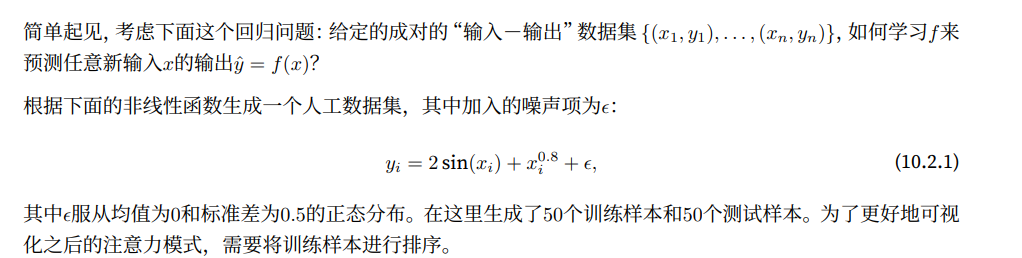

In [3]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

In [4]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

下⾯的函数将绘制所有的训练样本（样本由圆圈表⽰），不带噪声项的真实数据⽣成函数f（标记为“Truth”），
以及学习得到的预测函数（标记为“Pred”）。

In [5]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
            xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

## 2. 平均汇聚
先使⽤最简单的估计器来解决回归问题。基于平均汇聚来计算所有训练样本输出值的平均值

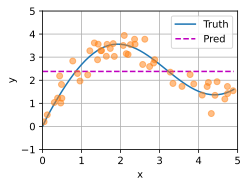

In [6]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## 3. 非参数注意力汇聚
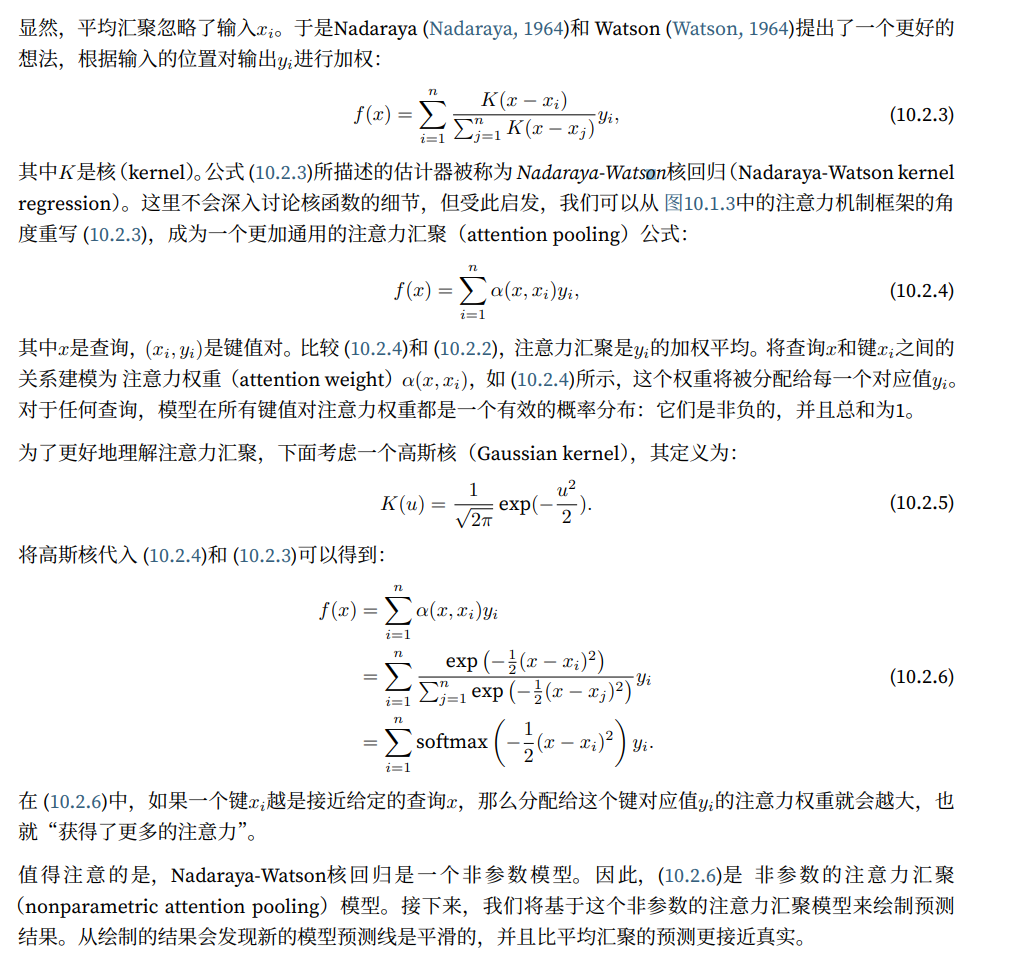

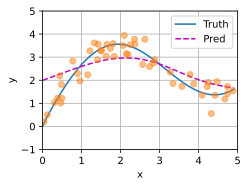

In [7]:
# 感觉这里非参数模型的意思是模型将变量作为主要的研究对象

# X_repeat的形状:(n_test,n_train),
# 每⼀⾏都包含着相同的测试输⼊（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每⼀⾏都包含着要在给定的每个查询的值（y_train）之间分配的注意⼒权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

现在来观察注意⼒的权重。这⾥测试数据的输⼊相当于查询，⽽训练数据的输⼊相当于键。因为两个输⼊都
是经过排序的，因此由观察可知“查询-键”对越接近，注意⼒汇聚的注意⼒权重就越⾼。


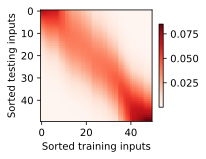

In [8]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                 xlabel='Sorted training inputs',
                 ylabel='Sorted testing inputs')

非参模型就是说模型不需要学习，只要给出足够多的数据，就能获得一个较好的模型

## 4. 带参数的注意力汇聚
⾮参数的Nadaraya-Watson核回归具有⼀致性（consistency）的优点：如果有⾜够的数据，此模型会收敛到
最优结果。尽管如此，我们还是可以轻松地将可学习的参数集成到注意⼒汇聚中。
（个人感觉就是把变量，权重都带进去计算）
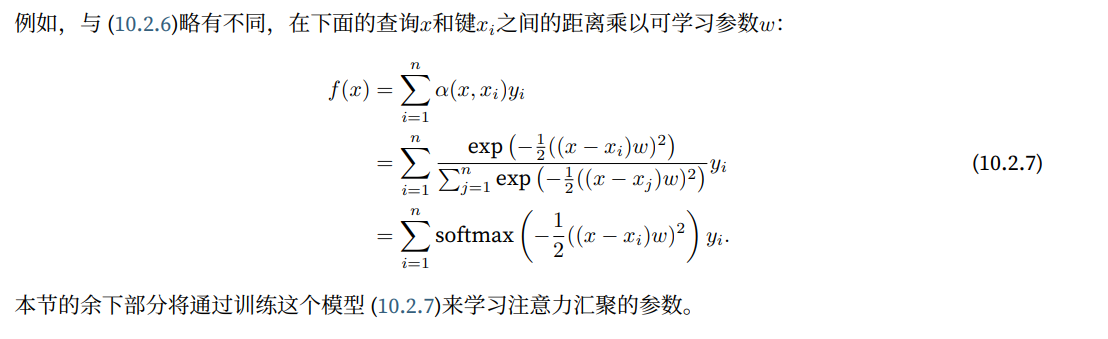

+ 批量矩阵乘法

In [9]:
X = torch.ones((2 ,1 ,4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

在注意⼒机制的背景中，我们可以使⽤⼩批量矩阵乘法来计算⼩批量数据中的加权平均值。

In [10]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape(2, 10)
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

+ 定义模型

In [11]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True))
    
    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w) ** 2 / 2, dim=1
        )
        return torch.bmm(self.attention_weights.unsqueeze(1),
                        values.unsqueeze(-1)).reshape(-1)

+ 训练

接下来，将训练数据集变换为键和值⽤于训练注意⼒模型。在带参数的注意⼒汇聚模型中，任何⼀个训练样
本的输⼊都会和除⾃⼰以外的所有训练样本的“键－值”对进⾏计算，从⽽得到其对应的预测输出。


In [12]:
# X_tile的形状:(n_train，n_train)，每⼀⾏都包含着相同的训练输⼊
X_title = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每⼀⾏都包含着相同的训练输出
Y_title = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_title[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_title[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

+ 训练带参数的注意⼒汇聚模型时，使⽤平⽅损失函数和随机梯度下降。

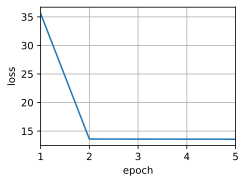

In [13]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

+ 如下所⽰，训练完带参数的注意⼒汇聚模型后可以发现：在尝试拟合带噪声的训练数据时，预测结果绘制的线不如之前⾮参数模型的平滑。


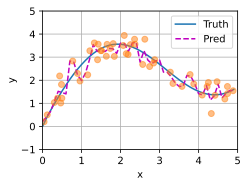

In [14]:
# keys的形状:(n_test，n_train)，每⼀⾏包含着相同的训练输⼊（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# values的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat =net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

与⾮参数的注意⼒汇聚模型相⽐，带参数的模型加⼊可学习的参数后，曲线在注意⼒权重较⼤的区域变得更不平滑。


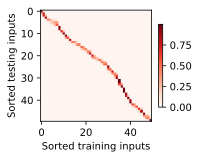

In [15]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                 xlabel='Sorted training inputs',
                 ylabel='Sorted testing inputs')

## 总结
+ Nadaraya-Watson核回归是具有注意⼒机制的机器学习范例。
+ Nadaraya-Watson核回归的注意⼒汇聚是对训练数据中输出的加权平均。从注意⼒的⻆度来看，分配给每个值的注意⼒权重取决于将值所对应的键和查询作为输⼊的函数。
+ 注意⼒汇聚可以分为⾮参数型和带参数型。
